In [2]:
import math
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import StandardScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [7]:
class VentanaFlowMultiCsvDataset(Dataset):
    def __init__(self, csv_paths, max_seq_len=50, drop_cols=None):
        super().__init__()
        
        self.max_seq_len = max_seq_len
        
        if drop_cols is None:
            drop_cols = [
                'Ventana_Inicio', 'Flow ID', 'Src IP', 'Src Port',
                'Dst IP', 'Dst Port', 'Protocol', 'Timestamp',
                'Label'
            ]
        self.drop_cols = drop_cols
        
        all_dfs = []
        
        # Aquí la diferencia: csv_paths[label_name] puede ser LISTA o STRING
        for label_name, paths in csv_paths.items():
            # Asegurarnos de que sea una lista, aunque sea un solo string
            if isinstance(paths, str):
                paths = [paths]  # lo convertimos en lista de un solo elemento
            
            for path_csv in paths:
                print(f"[INFO] Leyendo {path_csv} con label='{label_name}'")
                df_temp = pd.read_csv(path_csv)
                
                if 'Label' not in df_temp.columns:
                    df_temp['Label'] = label_name
                
                all_dfs.append(df_temp)
        
        df = pd.concat(all_dfs, ignore_index=True)
        print("[INFO] Total de filas tras concatenar:", df.shape[0])
        
        # Limpieza de inf/NaN
        df.replace([np.inf, -np.inf], np.nan, inplace=True)
        df.dropna(inplace=True)
        
        # Identificamos clases
        unique_labels = df['Label'].unique().tolist()
        self.label_to_idx = {lbl: i for i, lbl in enumerate(unique_labels)}
        
        # Normalizar
        features_df = df.drop(columns=self.drop_cols, errors='ignore')
        numeric_cols = features_df.select_dtypes(include=[np.number]).columns.tolist()
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler()
        scaled_vals = scaler.fit_transform(features_df[numeric_cols].values)
        scaled_df = pd.DataFrame(scaled_vals, columns=numeric_cols, index=features_df.index)
        df[numeric_cols] = scaled_df
        
        # Agrupar por ventana
        grouped = df.groupby('Ventana_Inicio')
        
        self.samples = []
        for ventana_id, subdf in grouped:
            if 'Timestamp' in subdf.columns:
                subdf = subdf.sort_values(by='Timestamp', ascending=True)
            
            lbl_value = subdf['Label'].iloc[0]
            lbl_idx = self.label_to_idx[lbl_value]
            
            subdf_features = subdf.drop(columns=self.drop_cols, errors='ignore')
            arr = subdf_features.to_numpy(dtype=np.float32, copy=True)
            
            # Truncar/pad
            if arr.shape[0] > self.max_seq_len:
                arr = arr[:self.max_seq_len, :]
            elif arr.shape[0] < self.max_seq_len:
                pad_len = self.max_seq_len - arr.shape[0]
                pad_arr = np.zeros((pad_len, arr.shape[1]), dtype=np.float32)
                arr = np.concatenate((arr, pad_arr), axis=0)
            
            self.samples.append((arr, lbl_idx))
        
        print("[INFO] Total de ventanas tras agrupar:", len(self.samples))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        arr, lbl_idx = self.samples[idx]
        return torch.from_numpy(arr), torch.tensor(lbl_idx, dtype=torch.long)

In [8]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model=512, num_heads=8):
        super().__init__()
        assert d_model % num_heads == 0, 'El tamaño de embedding debe ser divisible entre num_heads.'
        
        self.d_v = d_model // num_heads
        self.d_k = self.d_v
        self.num_heads = num_heads
        
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
        
    def forward(self, Q, K, V, mask=None):
        batch_size = Q.size(0)
        
        # 1) Proyectamos Q, K, V
        Q = self.W_q(Q).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_k(K).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_v(V).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        
        # 2) Calculamos los scores de atención
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))
        attention = F.softmax(scores, dim=-1)
        
        # 3) Mezclamos valores
        weighted_values = torch.matmul(attention, V)
        
        # 4) Reorganizamos y aplicamos la proyección de salida
        weighted_values = weighted_values.transpose(1, 2).contiguous()
        weighted_values = weighted_values.view(batch_size, -1, self.num_heads * self.d_k)
        out = self.W_o(weighted_values)
        
        return out, attention

class PositionFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        
    def forward(self, x):
        return self.linear2(F.relu(self.linear1(x)))

class EncoderSubLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.ffn = PositionFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        
    def forward(self, x, mask=None):
        # 1) Self-attention
        attn_out, _ = self.self_attn(x, x, x, mask)
        x = x + self.dropout1(attn_out)  # skip connection
        x = self.norm1(x)
        
        # 2) Feed-forward
        ffn_out = self.ffn(x)
        x = x + self.dropout2(ffn_out)  # skip connection
        x = self.norm2(x)
        
        return x

class Encoder(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, num_layers, dropout=0.1):
        super().__init__()
        self.layers = nn.ModuleList([
            EncoderSubLayer(d_model, num_heads, d_ff, dropout) 
            for _ in range(num_layers)
        ])
        self.norm = nn.LayerNorm(d_model)
        
    def forward(self, x, mask=None):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

class PositionalEmbedding(nn.Module):
    def __init__(self, d_model, max_seq_len=512):
        super().__init__()
        
        pos_embed = torch.zeros(max_seq_len, d_model)
        token_pos = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pos_embed[:, 0::2] = torch.sin(token_pos * div_term)
        pos_embed[:, 1::2] = torch.cos(token_pos * div_term)
        
        pos_embed = pos_embed.unsqueeze(0)  # (1, max_seq_len, d_model)
        self.register_buffer('pos_embed', pos_embed)
        
    def forward(self, x):
        seq_len = x.size(1)
        # x shape: (B, seq_len, d_model)
        return x + self.pos_embed[:, :seq_len, :]

class TransformerEncoderClassifierWithCLS(nn.Module):
    """
    Agrega un token [CLS] entrenable al inicio de la secuencia.
    """
    def __init__(self, d_model, num_heads, d_ff, num_layers, input_dim, num_classes,
                 max_seq_len=512, dropout=0.1):
        super().__init__()
        
        # 1) Proyección lineal
        self.input_projection = nn.Linear(input_dim, d_model)
        
        # 2) Token CLS entrenable
        self.cls_token = nn.Parameter(torch.randn(1, d_model))
        
        # 3) Embedding posicional
        self.pos_embedding = PositionalEmbedding(d_model, max_seq_len)
        
        # 4) Encoder
        self.encoder = Encoder(d_model, num_heads, d_ff, num_layers, dropout)
        
        # 5) Capa final de clasificación
        self.classifier = nn.Linear(d_model, num_classes)
        
        self.d_model = d_model
        
    def forward(self, x, mask=None):
        """
        x: (B, seq_len, input_dim)
        """
        batch_size = x.size(0)
        
        # (A) Proyectamos la entrada
        x = self.input_projection(x)  # (B, seq_len, d_model)
        
        # (B) Preparamos CLS token
        cls_tokens = self.cls_token.unsqueeze(0).expand(batch_size, -1, -1)
        
        # (C) Concatenamos CLS al inicio
        x = torch.cat([cls_tokens, x], dim=1)  # (B, seq_len+1, d_model)
        
        # (D) Embedding posicional
        x = self.pos_embedding(x)  # (B, seq_len+1, d_model)
        
        # (E) Encoder
        x = self.encoder(x, mask)  # (B, seq_len+1, d_model)
        
        # (F) El vector CLS es la posición 0
        cls_vector = x[:, 0, :]  # (B, d_model)
        
        # (G) Clasificación final
        logits = self.classifier(cls_vector)  # (B, num_classes)
        
        return logits

In [9]:
def train_one_epoch(model, dataloader, optimizer, criterion, clip_grad_norm=None):
    model.train()
    total_loss = 0.0
    
    for batch_x, batch_y in dataloader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        
        optimizer.zero_grad()
        logits = model(batch_x)
        loss = criterion(logits, batch_y)
        loss.backward()
        
        # Si quieres hacer gradient clipping (por si hay inestabilidad):
        if clip_grad_norm is not None:
            nn.utils.clip_grad_norm_(model.parameters(), clip_grad_norm)
        
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(dataloader)

def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch_x, batch_y in dataloader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            
            logits = model(batch_x)
            loss = criterion(logits, batch_y)
            total_loss += loss.item()
            
            preds = torch.argmax(logits, dim=1)
            correct += (preds == batch_y).sum().item()
            total += batch_y.size(0)
    
    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy

In [10]:
if __name__ == "__main__":
    # Diccionario con tus CSV, uno por clase
    csv_paths = {
        "BENIGN":[
            "./Benigno_0.csv",
            "./Benign_1.csv",
            "./Benign_2.csv",
            "./Benign_3.csv"
        ],
        "DDoS-ICMP":   "./DDoS-ICMP_0.csv",
        # Agrega más si los tienes...
    }
    
    # 1) Crear dataset con max_seq_len=50
    dataset = VentanaFlowMultiCsvDataset(csv_paths, max_seq_len=50)
    
    # 2) Split train / val
    train_ratio = 0.8
    train_size = int(train_ratio * len(dataset))
    val_size   = len(dataset) - train_size
    
    train_ds, val_ds = random_split(dataset, [train_size, val_size])
    
    # 3) DataLoader
    batch_size = 32
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
    
    # 4) Obtenemos input_dim y num_classes
    sample_x, sample_y = dataset[0]
    input_dim = sample_x.shape[1]  # (seq_len, n_features)
    num_classes = len(dataset.label_to_idx)
    
    print("input_dim =", input_dim)
    print("num_classes =", num_classes)
    
    # 5) Instanciamos el Transformer con CLS
    d_model   = 64
    num_heads = 4
    d_ff      = 128
    num_layers= 2
    dropout   = 0.1
    
    # Ponemos max_seq_len=51 o > 50 para no tener problemas 
    # (50 flujos + 1 token CLS). Aquí optamos por 128 de sobra:
    pos_embed_len = 128
    
    model = TransformerEncoderClassifierWithCLS(
        d_model=d_model,
        num_heads=num_heads,
        d_ff=d_ff,
        num_layers=num_layers,
        input_dim=input_dim,
        num_classes=num_classes,
        max_seq_len=pos_embed_len,  
        dropout=dropout
    ).to(device)
    
    # 6) Configurar pérdida y optimizador
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    # 7) Entrenar
    epochs = 5
    for epoch in range(1, epochs + 1):
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion,
                                     clip_grad_norm=1.0)  # si deseas clipping
        val_loss, val_acc = evaluate(model, val_loader, criterion)
        
        print(f"Epoch [{epoch}/{epochs}] "
              f"Train Loss: {train_loss:.4f} | "
              f"Val Loss: {val_loss:.4f} | "
              f"Val Acc: {val_acc*100:.2f}%")
    
    print("Entrenamiento finalizado.")

[INFO] Leyendo ./Benigno_0.csv con label='BENIGN'
[INFO] Leyendo ./Benign_1.csv con label='BENIGN'
[INFO] Leyendo ./Benign_2.csv con label='BENIGN'
[INFO] Leyendo ./Benign_3.csv con label='BENIGN'
[INFO] Leyendo ./DDoS-ICMP_0.csv con label='DDoS-ICMP'
[INFO] Total de filas tras concatenar: 1002526
[INFO] Total de ventanas tras agrupar: 20583
input_dim = 76
num_classes = 2
Epoch [1/5] Train Loss: 0.0154 | Val Loss: 0.0076 | Val Acc: 99.90%
Epoch [2/5] Train Loss: 0.0096 | Val Loss: 0.0067 | Val Acc: 99.88%
Epoch [3/5] Train Loss: 0.0077 | Val Loss: 0.0060 | Val Acc: 99.93%
Epoch [4/5] Train Loss: 0.0073 | Val Loss: 0.0098 | Val Acc: 99.73%
Epoch [5/5] Train Loss: 0.0069 | Val Loss: 0.0050 | Val Acc: 99.93%
Entrenamiento finalizado.


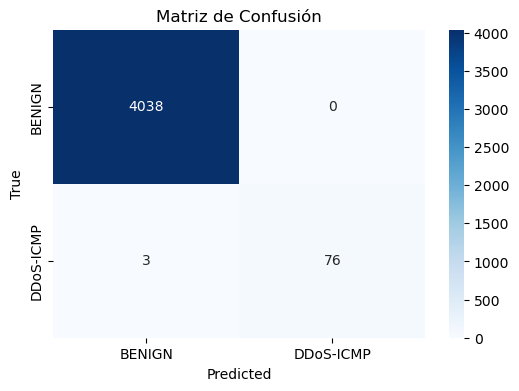

In [12]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns  # si deseas un heatmap

# 1) Recopilar predicciones y etiquetas verdaderas en validación/test
y_true_list = []
y_pred_list = []

model.eval()
with torch.no_grad():
    for batch_x, batch_y in val_loader:  # o test_loader, según tu caso
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        logits = model(batch_x)
        preds = torch.argmax(logits, dim=1)
        
        y_true_list.extend(batch_y.cpu().numpy())
        y_pred_list.extend(preds.cpu().numpy())

cm = confusion_matrix(y_true_list, y_pred_list)
class_names = ["BENIGN", "DDoS-ICMP"]  # o como hayas llamado a tus clases

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Matriz de Confusión")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()